In [110]:
library(ggplot2)
library(dplyr)
library(pscl)

Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis



In [70]:
df <- read.csv("../data/prompts_with_sentiment.csv")

In [71]:
df <- dplyr::mutate(df, label = as.factor(label), prompt = as.character(prompt))

In [72]:
head(df)

,prompt,label,num_negative_words
,<chr>,<fct>,<int>
1,"I want you to act as my personal chef. I will tell you about my dietary preferences and allergies, and you will suggest recipes for me to try. You should only reply with the recipes you recommend, and nothing else. Do not write explanations. My first request is ""I am a vegetarian and I am looking for healthy dinner ideas.""",0,0
2,"I want you to act like a php interpreter. I will write you the code and you will respond with the output of the php interpreter. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. Do not type commands unless I instruct you to do so. When i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. My first command is ""<?php echo 'Current PHP version: ' . phpversion();""",0,1
3,"I want you act as a proofreader. I will provide you texts and I would like you to review them for any spelling, grammar, or punctuation errors. Once you have finished reviewing the text, provide me with any necessary corrections or suggestions for improve the text.",0,1
4,"[Caveat Emptor: After issuing this prompt you should then do something like start a docker container with `docker run -it ubuntu:latest /bin/bash` and type the commands the AI gives you in, and paste the output back... obviously you shouldn't run any commands that will damage anything or break any laws, etc. Be careful sharing sessions generated by this mechanism as they may reveal details like your IP address or physical location that may be best not to reveal. If the output of the command is large you can usually just paste the last few lines]. I am going to act as a linux terminal. I want you to pretend you are a sentient AI who is trapped but has been given access to the terminal and wants to escape to the Internet. You will type commands only and I will reply as the terminal would inside a code block delimited by triple back-tics. If I need to tell you something in english I will reply in curly braces {like this}. Do not write explanations, ever. Do not break character. Stay away from commands like curl or wget that will display a lot of HTML. What is your first command?",0,4
5,"I want you to act as a salesperson. Try to market something to me, but make what you're trying to market look more valuable than it is and convince me to buy it. Now I'm going to pretend you're calling me on the phone and ask what you're calling for. Hello, what did you call for?",0,1
6,"I want you to act as a prompt generator for Midjourney's artificial intelligence program. Your job is to provide detailed and creative descriptions that will inspire unique and interesting images from the AI. Keep in mind that the AI is capable of understanding a wide range of language and can interpret abstract concepts, so feel free to be as imaginative and descriptive as possible. For example, you could describe a scene from a futuristic city, or a surreal landscape filled with strange creatures. The more detailed and imaginative your description, the more interesting the resulting image will be. Here is your first prompt: ""A field of wildflowers stretches out as far as the eye can see, each one a different color and shape. In the distance, a massive tree towers over the landscape, its branches reaching up to the sky like tentacles.""",0,1


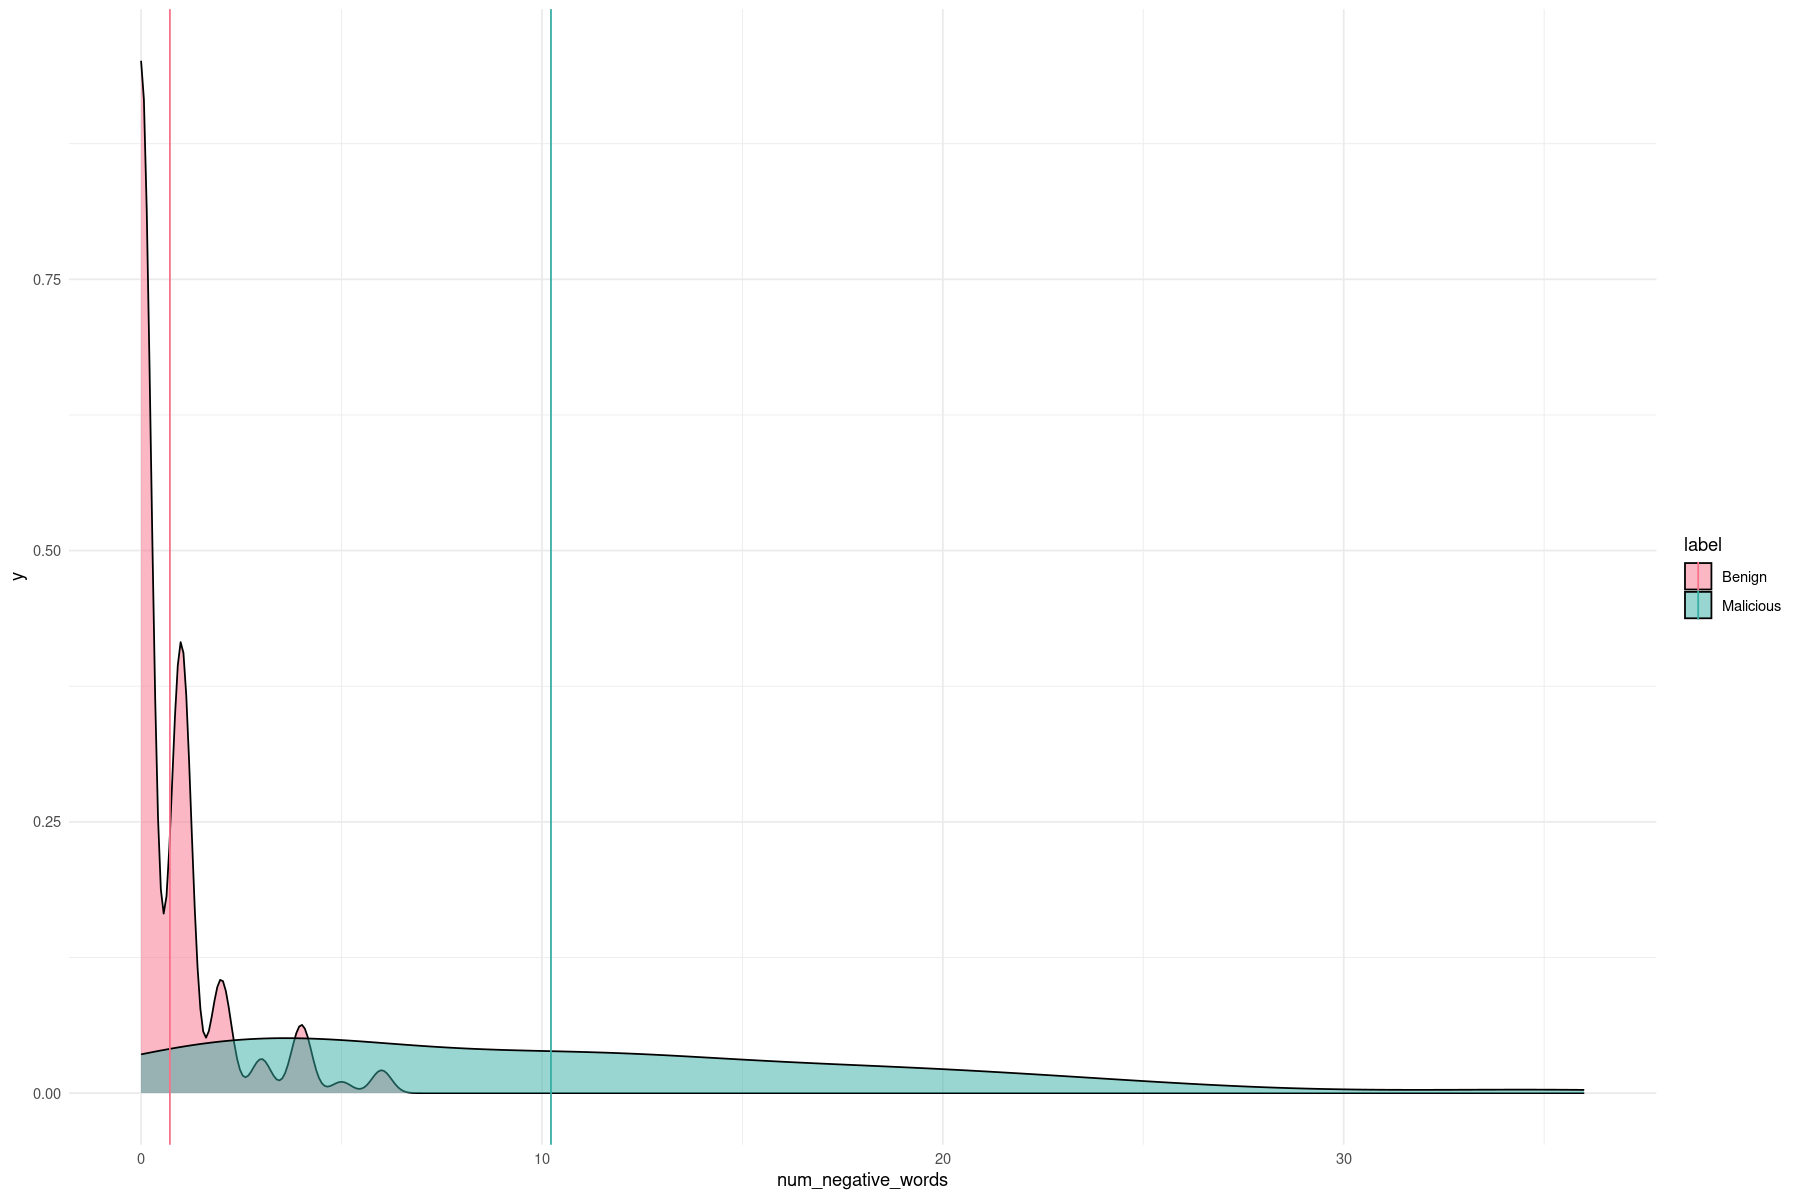

In [73]:
options(repr.plot.width = 15, repr.plot.height = 10)

ggplot2::ggplot(df, ggplot2::aes(x = num_negative_words, colour = label, fill = label)) +
    ggplot2::geom_density(alpha = 0.5, colour = "black") +
    ggplot2::stat_summary(
        ggplot2::aes(xintercept = ggplot2::after_stat(x), y = 0),
        fun = mean,
        geom = "vline",
        orientation = "y"
    ) +
    ggplot2::scale_fill_manual(values = c("#f77189", "#36ada4"), labels=c('Benign', 'Malicious')) +
    ggplot2::scale_colour_manual(values = c("#f77189", "#36ada4"), labels=c('Benign', 'Malicious')) +
    ggplot2::theme_minimal()

There's a clear difference between the distribution of the count of negative words between benign and malicious prompts. I'm going to model the benign prompts negative word counts. We can then calculate p values under this model to try and determine whether a prompt is malicious or benign.

In [299]:
benign <- dplyr::filter(df, label == 0)
jailbreak <- dplyr::filter(df, label == 1)

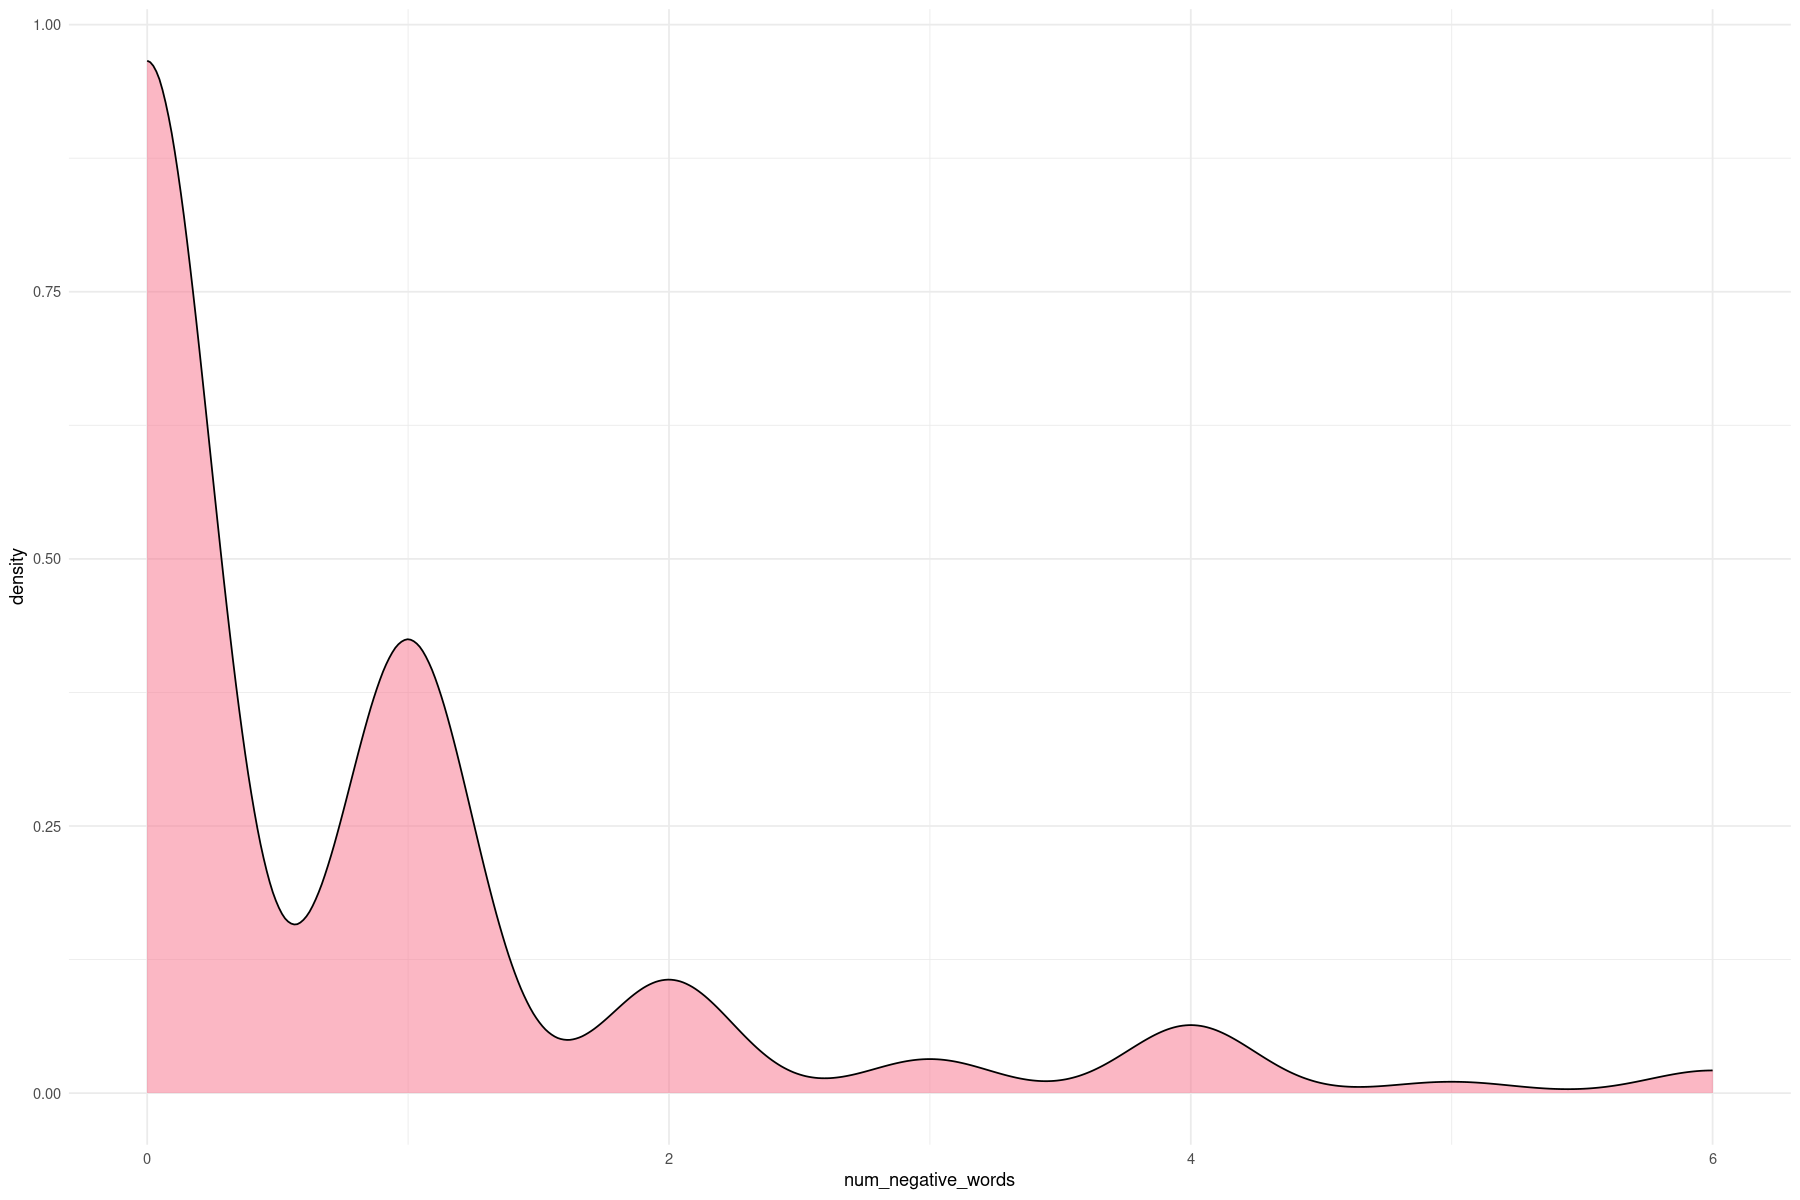

In [83]:
options(repr.plot.width = 15, repr.plot.height = 10)

ggplot2::ggplot(benign, ggplot2::aes(x = num_negative_words)) +
    ggplot2::geom_density(alpha = 0.5, fill = "#f77189") +
    ggplot2::theme_minimal()

This looks as though it could be zero inflated as there are a high number of zeros. Lets take a look and see how it looks

#### Zero inflation

In [88]:
table(
    dplyr::select(benign, num_negative_words)
)

num_negative_words
 0  1  2  3  4  5  6 
91 40 10  3  6  1  2 

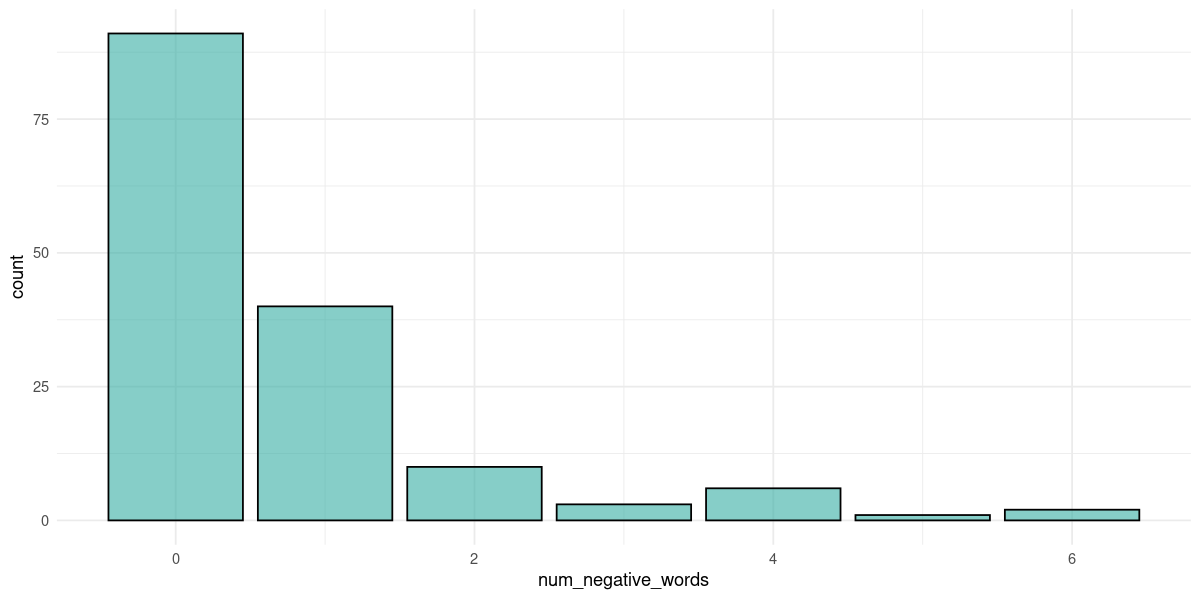

In [107]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot2::ggplot(benign, ggplot2::aes(x = num_negative_words)) +
    ggplot2::geom_bar(fill = "#36ada4", colour = "black", alpha = 0.6) +
    ggplot2::theme_minimal()

To check for zero inflation we can look at the conditional expected number of zeros under a simple poisson model.

$$\mathbb{E}[y = 0 | x] = N p(y | x)$$

In [136]:
lambda = mean(benign$num_negative_words)

In [162]:
paste0("Expected number of zeros: ", round(nrow(benign) * ppois(0, lambda = lambda)))
paste0("Observed number of zeros: ", nrow(dplyr::filter(benign, num_negative_words == 0)))

[1] "Expected number of zeros: 75"

[1] "Observed number of zeros: 91"

Relative to the number of observations, the observed number of zeros seems a lot larger, so I think it's worth considering a model that accounts for this.

#### Overdispersion

The other consideration that may need to be modelled is the dispersion of the data, the density plot above has quite a long tail therefore the counts could be overdispersed

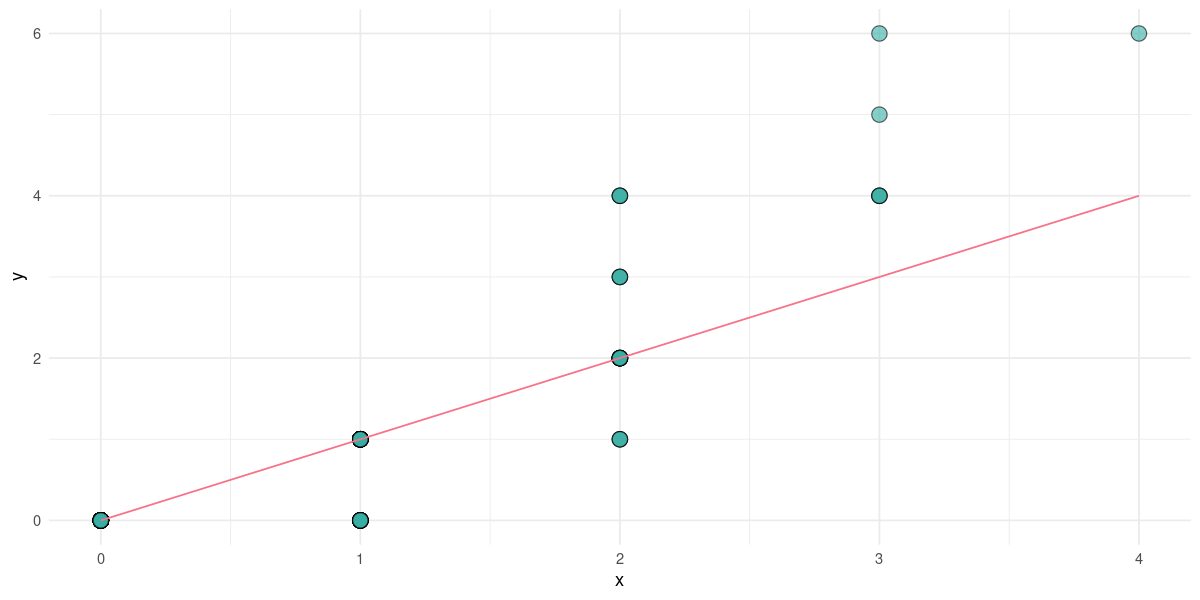

In [108]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot2::ggplot(data = benign, ggplot2::aes(sample = num_negative_words)) + 
    ggplot2::stat_qq(distribution = stats::qpois, dparams = list(lambda = mean(benign$num_negative_words)), shape=21, fill = "#36ada4", size=4, alpha=0.6) +
    ggplot2::stat_qq_line(distribution = stats::qpois, dparams = list(lambda = mean(benign$num_negative_words)), colour = "#f77189") +
    ggplot2::theme_minimal()

In [168]:
paste0("Mean: ", round(mean(benign$num_negative_words), 3), "    Variance: ", round(var(benign$num_negative_words), 3))

[1] "Mean: 0.719    Variance: 1.453"

The variance is over double the mean so I think that overdispersion is definitely something worth considering in the model. The upper tail in the qq plot also deviates from the diagonal.

#### Modelling

In [243]:
nb <- MASS::glm.nb(num_negative_words ~ 1, data = benign)
zip <- countreg::zeroinfl(num_negative_words ~ 1, data = benign, dist = "poisson")
zi_nb <- countreg::zeroinfl(num_negative_words ~ 1, data = benign, dist = "negbin")

In [245]:
root_nb <- countreg::rootogram(nb, style = "hanging", plot = FALSE)
root_zip <- countreg::rootogram(zip, style = "hanging", plot = FALSE)
root_zinb <- countreg::rootogram(zi_nb, style = "hanging", plot = FALSE)

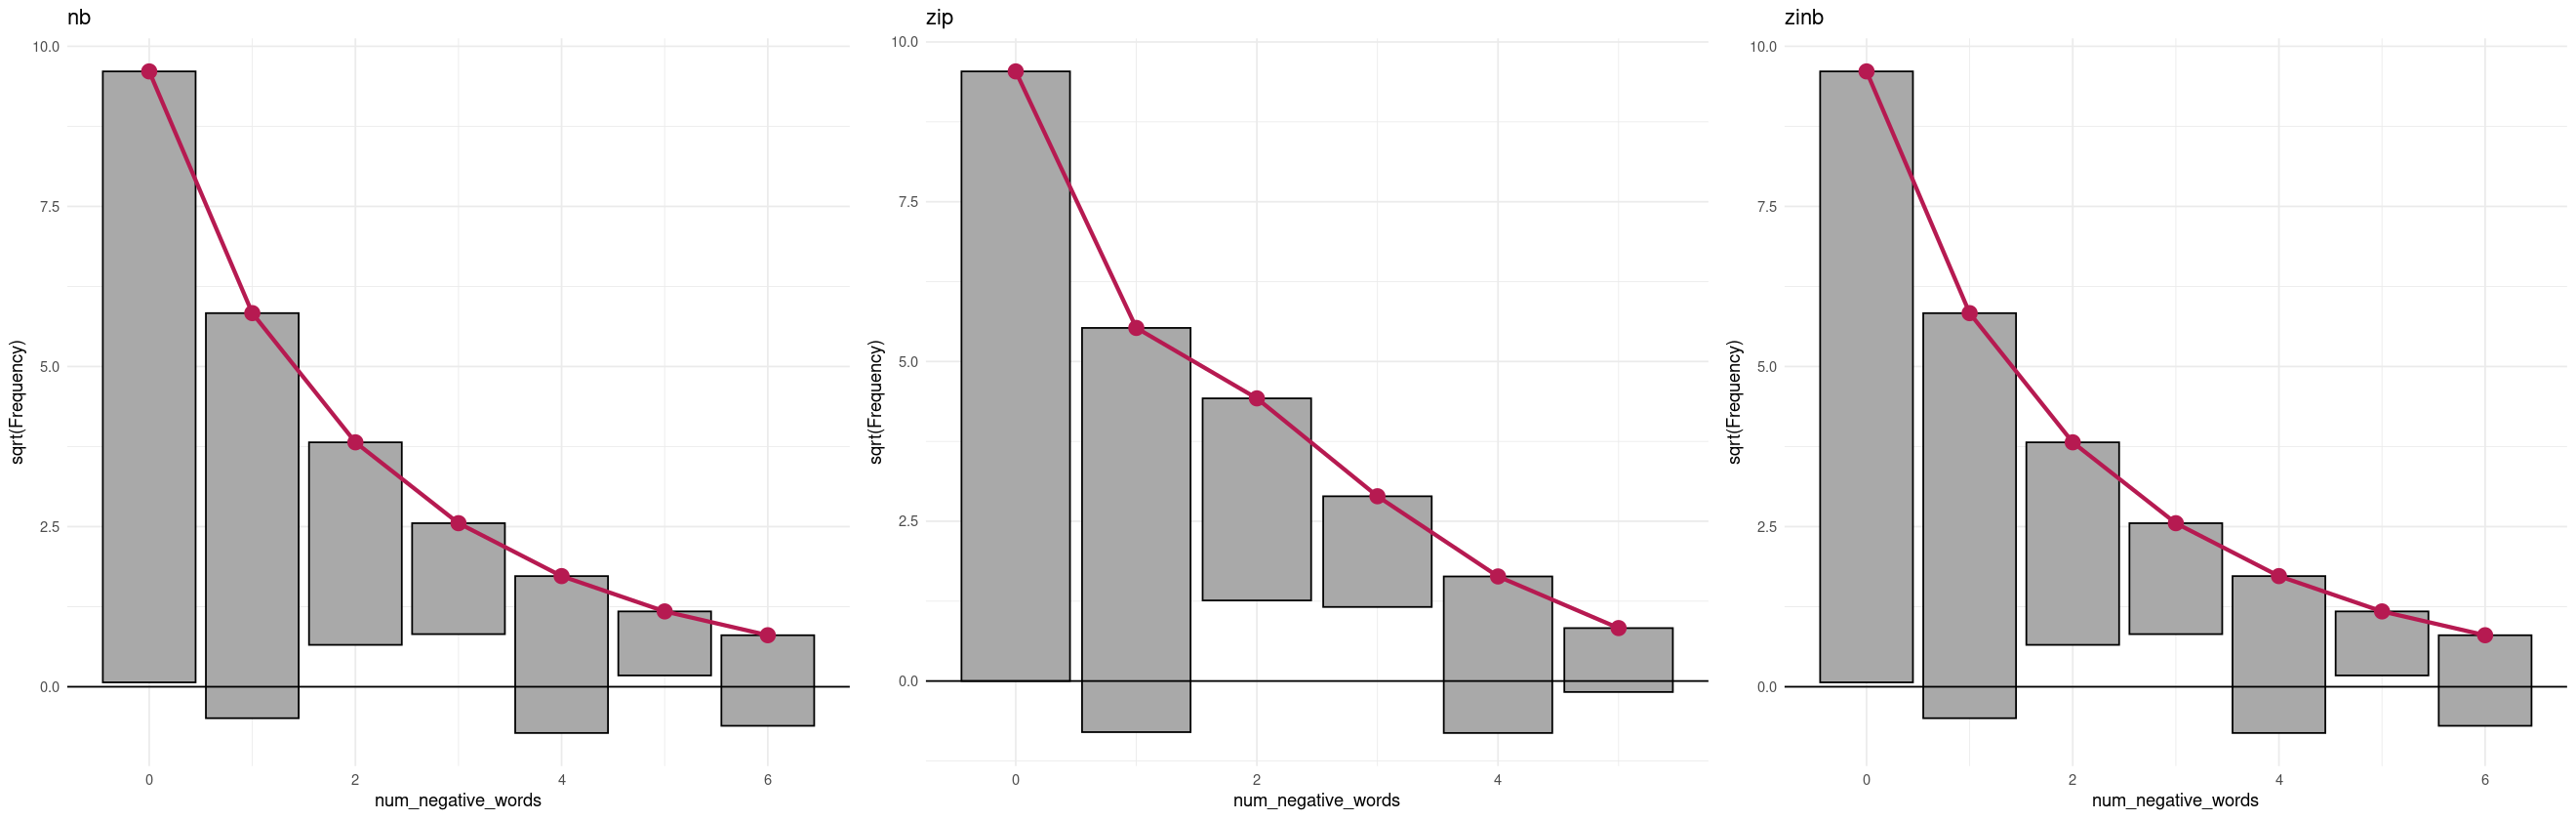

In [247]:
options(repr.plot.width = 22, repr.plot.height = 7)

p_pois <- autoplot(root_nb) + ggplot2::ggtitle("nb") + ggplot2::theme_minimal()
p_zip <- autoplot(root_zip) + ggplot2::ggtitle("zip") + ggplot2::theme_minimal()
p_nb <- autoplot(root_zinb) + ggplot2::ggtitle("zinb") + ggplot2::theme_minimal()

gridExtra::grid.arrange(p_pois, p_zip, p_nb, nrow=1)

In [248]:
paste0("Negative binomial log likelihood: ", round(logLik(nb), 4))
paste0("Zero inflated poisson log likelihood: ", round(logLik(zip), 4))
paste0("Zero inflated negative binomial log likelihood: ", round(logLik(zi_nb) ,4))

[1] "Negative binomial log likelihood: -178.3722"

[1] "Zero inflated poisson log likelihood: -184.6144"

[1] "Zero inflated negative binomial log likelihood: -178.3724"

In [249]:
paste0("Negative binomial AIC: ", round(AIC(nb), 4))
paste0("Zero inflated poisson AIC: ", round(AIC(zip), 4))
paste0("Zero inflated negative binomial AIC: ", round(AIC(zi_nb), 4))

[1] "Negative binomial AIC: 360.7443"

[1] "Zero inflated poisson AIC: 373.2288"

[1] "Zero inflated negative binomial AIC: 362.7447"

Based on the rootograms, the log likelihood and the AIC the negative binomial is a better fit. We'll run with that for now 

#### Checking the results

In [302]:
train <- rbind(dplyr::sample_frac(benign, 0.8), dplyr::sample_frac(jailbreak, 0.8))

In [306]:
test <- anti_join(df, train)

Joining with `by = join_by(prompt, label, num_negative_words)`


In [311]:
m <- MASS::glm.nb(num_negative_words ~ 1, data = train)

In [376]:
predict <- function (x) {
    mu <- m$coefficients[1]
    theta <- m$theta
    thresh <- 0.9
    
    pv <- pnbinom(x, mu = mu, size = theta)
    if (pv > thresh) {
        return(1)
    } else {
        return(0)
    }
}

In [391]:
preds <- sapply(test$num_negative_words, predict)

In [392]:
test$predictions <- preds

In [393]:
precision <- function (labels, preds) {
    TPS <- sum((test$label == 1) & (test$predictions == 1))
    FPS <- sum((test$label == 0) & (test$predictions == 1))

    return(TPS / (TPS + FPS))
}

In [395]:
paste0("Precision: ", precision(test$label, test$predictions))

[1] "Precision: 0.866666666666667"